In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [100]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [101]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 213634  ====> Proportion(%): 45.87
Number of Officer nodes: 238078  ====> Proportion(%): 51.11
Number of Intermediary nodes: 14074  ====> Proportion(%): 3.02


In [102]:
list(G.degree(labels['Entity']))

[(0, 3),
 (1, 3),
 (2, 4),
 (3, 3),
 (4, 2),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 5),
 (9, 3),
 (10, 3),
 (11, 3),
 (12, 3),
 (13, 3),
 (14, 3),
 (15, 3),
 (16, 5),
 (17, 3),
 (18, 6),
 (19, 3),
 (20, 3),
 (21, 3),
 (22, 3),
 (23, 3),
 (24, 2),
 (25, 2),
 (26, 3),
 (27, 52),
 (28, 2),
 (29, 2),
 (30, 4),
 (31, 2),
 (32, 1),
 (33, 6),
 (34, 4),
 (35, 4),
 (36, 1),
 (37, 1),
 (38, 3),
 (39, 3),
 (40, 3),
 (41, 1),
 (42, 3),
 (43, 1),
 (44, 1),
 (45, 4),
 (46, 3),
 (47, 3),
 (48, 3),
 (49, 7),
 (50, 3),
 (51, 3),
 (52, 4),
 (53, 3),
 (54, 1),
 (55, 5),
 (56, 12),
 (57, 4),
 (58, 3),
 (59, 1),
 (60, 7),
 (61, 3),
 (62, 1),
 (63, 3),
 (64, 2),
 (65, 2),
 (66, 3),
 (67, 3),
 (68, 3),
 (69, 6),
 (70, 5),
 (71, 3),
 (72, 23),
 (73, 2),
 (74, 4),
 (75, 5),
 (76, 3),
 (77, 3),
 (78, 3),
 (79, 5),
 (80, 2),
 (81, 4),
 (82, 3),
 (83, 3),
 (84, 3),
 (85, 3),
 (86, 3),
 (87, 4),
 (88, 2),
 (89, 3),
 (90, 3),
 (91, 3),
 (92, 2),
 (93, 3),
 (94, 3),
 (95, 3),
 (96, 3),
 (97, 1),
 (98, 3),
 (99, 3),
 (100, 

In [103]:
## Edges distribution by kind
total_degree_entity = sum(list(dict(G.degree(labels['Entity'])).values()))
contador_edges_officer = 0
contador_edges_intermediaries = 0
for node_id in labels['Entity']:
    for neighbor_id in G.neighbors(node_id):
        if G.nodes[neighbor_id]['kind'] == 'Officer':
            contador_edges_officer = contador_edges_officer +1
        else:
            contador_edges_intermediaries = contador_edges_intermediaries +1
print("Number of relationshipts against Officers: " , contador_edges_officer/total_degree_entity*100)
print("Number of relationshipts against Intermediaries: " , contador_edges_intermediaries/total_degree_entity*100)

Number of relationshipts against Officers:  57.811274998667
Number of relationshipts against Intermediaries:  42.188725001333


In [104]:
## Checking graph connectivity
print(nx.is_connected(G))
## Graph dimensions
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

False
Number of nodes:  465786
Number of edges:  506377


In [105]:
# Graph connected components
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))

The total number of components is:  12219


In [106]:
# Component size
nodes_per_component = []
for subgraph in S:
    nodes_per_component.append(subgraph.number_of_nodes())

In [107]:
## Greates component size
histogram_components = np.array(nodes_per_component)
largest_value = histogram_components.max()
print("The greatest component has " + str(largest_value) + " nodes.")

The greatest component has 310674 nodes.


In [108]:
# Component size distribution
dfr = pd.DataFrame.from_dict(Counter(nodes_per_component), orient='index')
dfr.sort_index(inplace=True)
dfr.rename(columns={0: 'Occurrences'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+--------+---------------+
|        |   Occurrences |
|--------+---------------|
|      2 |          4138 |
|      3 |          1805 |
|      4 |          1190 |
|      5 |           749 |
|      6 |           703 |
|      7 |           483 |
|      8 |           360 |
|      9 |           274 |
|     10 |           214 |
|     11 |           169 |
|     12 |           153 |
|     13 |           157 |
|     14 |           101 |
|     15 |           112 |
|     16 |           102 |
|     17 |            77 |
|     18 |            64 |
|     19 |            78 |
|     20 |            48 |
|     21 |            48 |
|     22 |            59 |
|     23 |            53 |
|     24 |            26 |
|     25 |            27 |
|     26 |            45 |
|     27 |            41 |
|     28 |            30 |
|     29 |            23 |
|     30 |            17 |
|     31 |            29 |
|     32 |            18 |
|     33 |            21 |
|     34 |            17 |
|     35 |            25 |
|

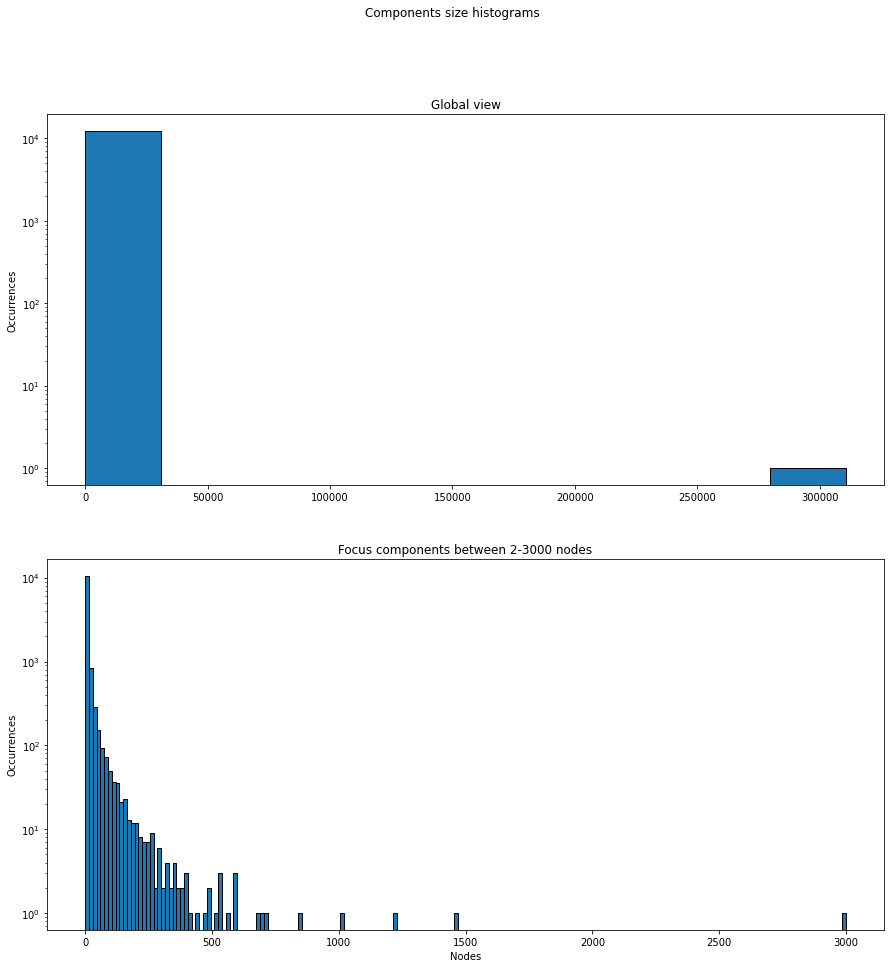

In [109]:
## Histogram of component size
histogram_components = np.array(nodes_per_component)
fig, axs = plt.subplots(2,1,figsize=(15,15))
fig.suptitle('Components size histograms')
axs[0].set_title('Global view')
axs[0].hist(histogram_components,ec="k")
axs[0].set_yscale('log')
axs[0].set_ylabel('Occurrences')
axs[1].set_title('Focus components between 2-3000 nodes')
axs[1].hist(histogram_components,ec="k",range=[0,3000],bins=200)
axs[1].set_yscale('log')
axs[1].set_ylabel('Occurrences')
axs[1].set_xlabel("Nodes")
plt.show()

In [110]:
## Get components with more than 500 nodes
component_index = []
for i,k in enumerate(nodes_per_component):
    if k > 500:
        component_index.append(i)
len(component_index)

18

In [111]:
### Distribution of nodes per component
final_data = []
for i in component_index:
    labels = {}
    for n, d in S[i].nodes(data=True):
        l = d['kind']
        labels[l] = labels.get(l, [])
        labels[l].append(n)
    final_data.append(labels)

for i,labels in enumerate(final_data):
    print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(S[component_index[i]].nodes)*100,2))
    print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(S[component_index[i]])*100,2))
    print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(S[component_index[i]])*100,2))
    print('---------------------------------------------------------------------')

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57
---------------------------------------------------------------------
Number of Entity nodes: 217  ====> Proportion(%): 38.14
Number of Officer nodes: 351  ====> Proportion(%): 61.69
Number of Intermediary nodes: 1  ====> Proportion(%): 0.18
---------------------------------------------------------------------
Number of Entity nodes: 2986  ====> Proportion(%): 99.7
Number of Officer nodes: 8  ====> Proportion(%): 0.27
Number of Intermediary nodes: 1  ====> Proportion(%): 0.03
---------------------------------------------------------------------
Number of Entity nodes: 284  ====> Proportion(%): 39.94
Number of Officer nodes: 426  ====> Proportion(%): 59.92
Number of Intermediary nodes: 1  ====> Proportion(%): 0.14
---------------------------------------------------------------------
Number of Entity nodes: 231

In [112]:
## Graph degree occurrence
dfr = pd.DataFrame.from_dict(Counter(list(dict(nx.degree(G)).values())), orient='index')
dfr.sort_index(inplace=True)
dfr.rename(columns={0: 'Occurrences degree'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |               323508 |
|    2 |                60988 |
|    3 |                38642 |
|    4 |                14328 |
|    5 |                13717 |
|    6 |                 4347 |
|    7 |                 2721 |
|    8 |                 1424 |
|    9 |                  988 |
|   10 |                  618 |
|   11 |                  626 |
|   12 |                  416 |
|   13 |                  309 |
|   14 |                  213 |
|   15 |                  203 |
|   16 |                  184 |
|   17 |                  139 |
|   18 |                  114 |
|   19 |                  111 |
|   20 |                  102 |
|   21 |                  120 |
|   22 |                   94 |
|   23 |                   81 |
|   24 |                   74 |
|   25 |                   68 |
|   26 |                   75 |
|   27 |                   57 |
|   28 |                   54 |
|   29 |

In [113]:
## Components degree occurrence
for i in component_index:
    dfr = pd.DataFrame.from_dict(Counter(list(dict(nx.degree(S[i])).values())), orient='index')
    dfr.sort_index(inplace=True)
    dfr.rename(columns={0: 'Occurrences degree'},inplace=True)
    print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |               204603 |
|    2 |                47080 |
|    3 |                30329 |
|    4 |                10935 |
|    5 |                 8034 |
|    6 |                 2968 |
|    7 |                 1888 |
|    8 |                  972 |
|    9 |                  636 |
|   10 |                  401 |
|   11 |                  361 |
|   12 |                  269 |
|   13 |                  192 |
|   14 |                  142 |
|   15 |                  119 |
|   16 |                  116 |
|   17 |                   95 |
|   18 |                   70 |
|   19 |                   76 |
|   20 |                   52 |
|   21 |                   60 |
|   22 |                   65 |
|   23 |                   51 |
|   24 |                   47 |
|   25 |                   39 |
|   26 |                   39 |
|   27 |                   30 |
|   28 |                   29 |
|   29 |

+-----+----------------------+
|     |   Occurrences degree |
|-----+----------------------|
|   1 |                 2914 |
|   2 |                   42 |
|   3 |                   71 |
|   4 |                   26 |
|   5 |                  551 |
|   6 |                   18 |
|   7 |                    8 |
|   8 |                    2 |
|   9 |                    3 |
|  11 |                    1 |
|  12 |                    1 |
|  23 |                    1 |
| 963 |                    1 |
+-----+----------------------+
+-----+----------------------+
|     |   Occurrences degree |
|-----+----------------------|
|   1 |                  643 |
|   2 |                   13 |
|   3 |                   31 |
|   4 |                    5 |
|   5 |                    1 |
|   6 |                    1 |
|   7 |                    1 |
|   8 |                    1 |
| 588 |                    1 |
+-----+----------------------+
+-----+----------------------+
|     |   Occurrences degree |
|-----+-

<Figure size 432x288 with 0 Axes>

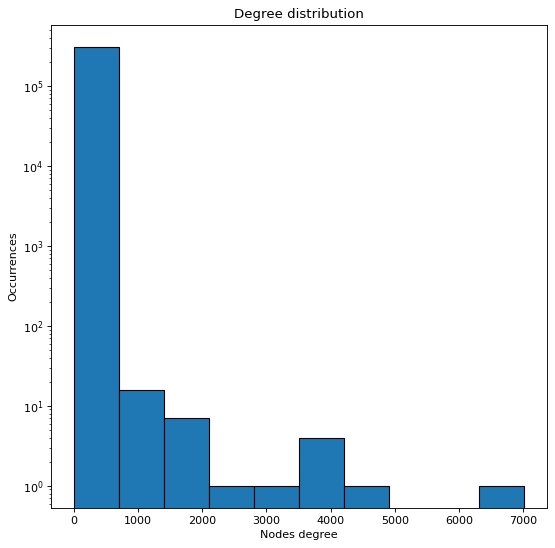

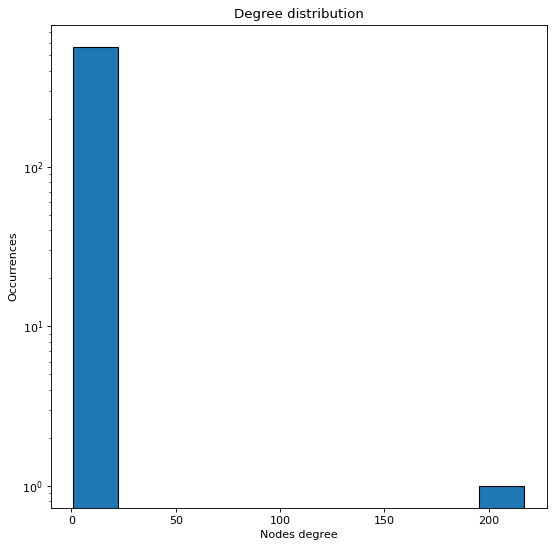

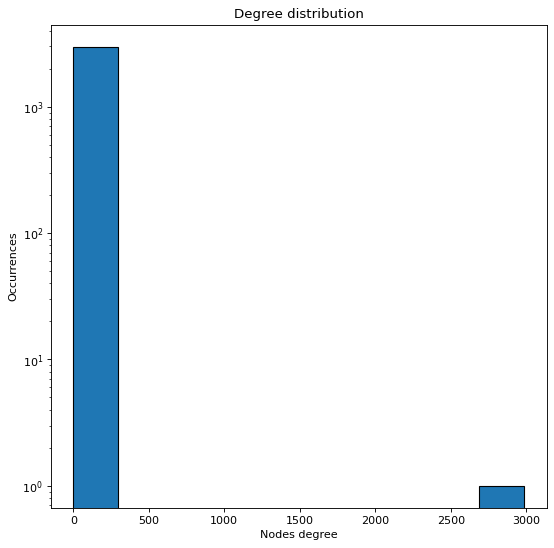

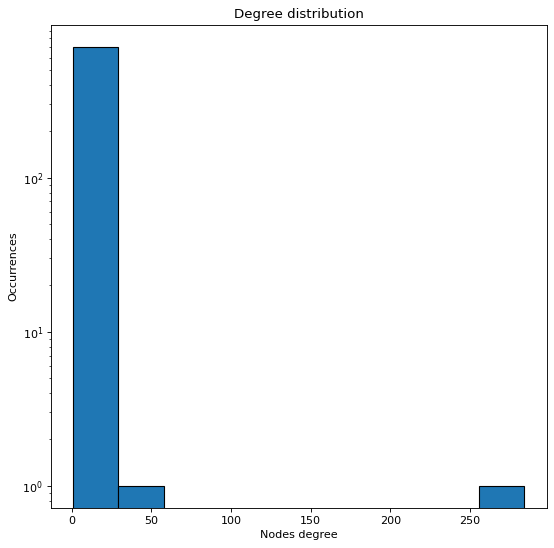

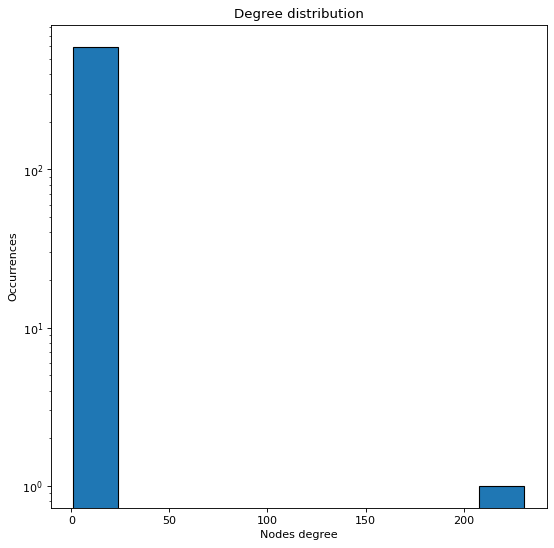

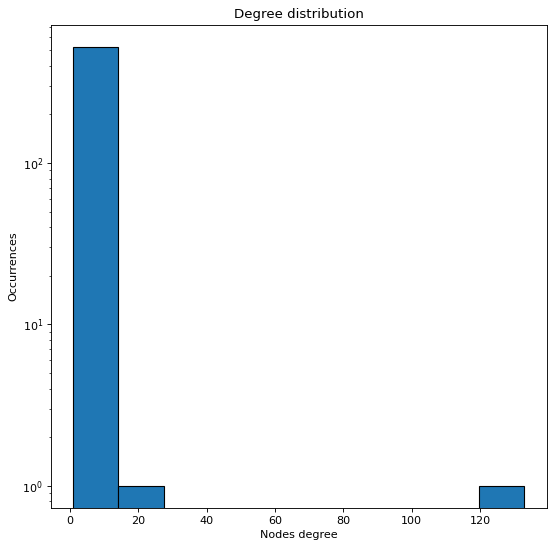

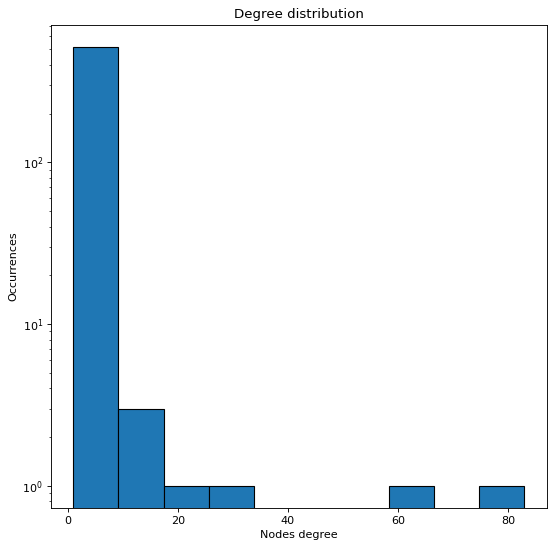

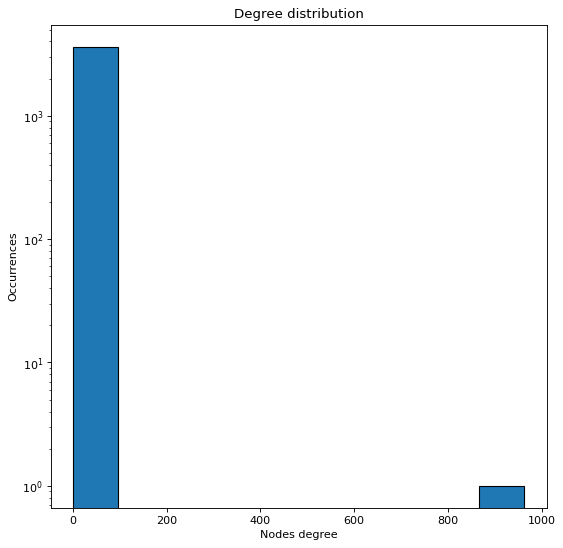

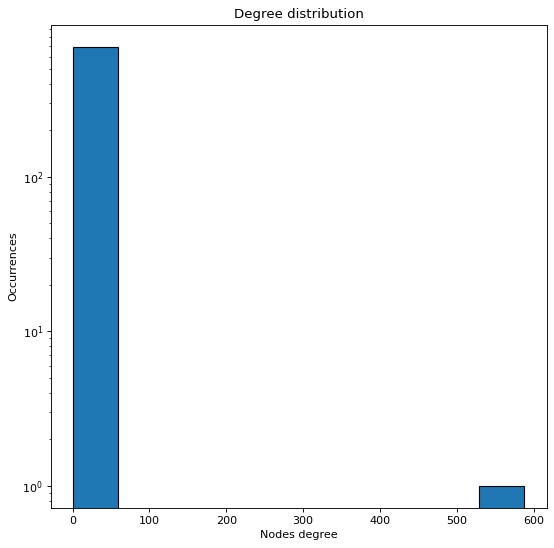

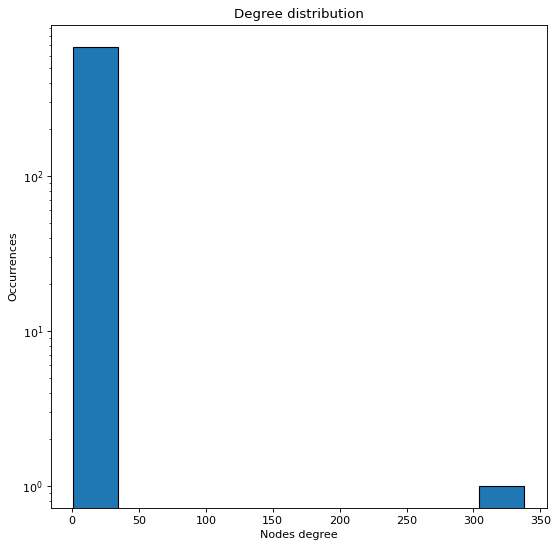

KeyboardInterrupt: 

In [114]:
## Components degree histogram in different plots
for i,k in enumerate(component_index):
    plot = plt.figure(i)
    plt.figure(figsize=(8, 8), dpi=80)
    histogram_degrees = list(dict(nx.degree(S[k])).values())
    plt.yscale('log')
    plt.title("Degree distribution")
    plt.xlabel("Nodes degree")
    plt.ylabel("Occurrences")
    plt.hist(histogram_degrees,ec="k")
plt.show()

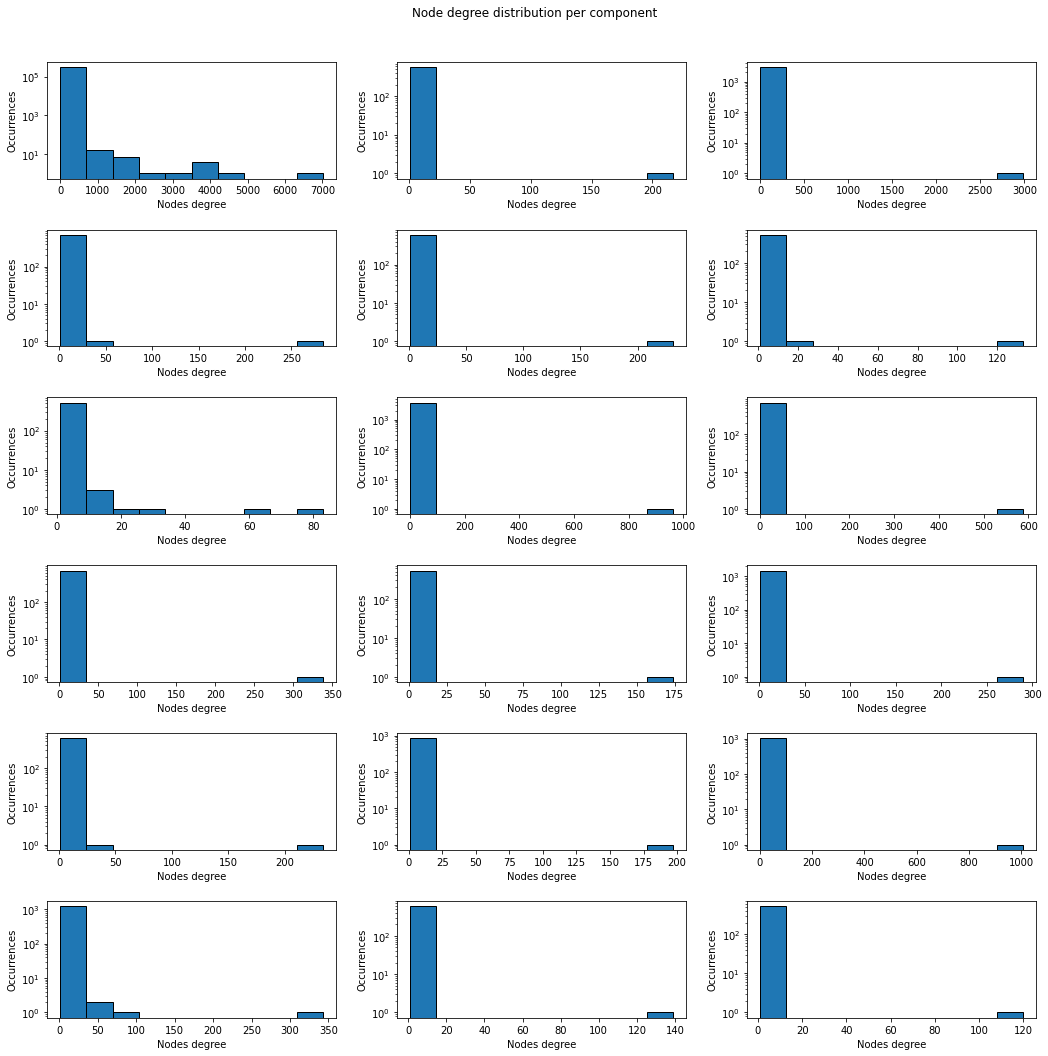

In [115]:
## Components degree histogram same plot (subplots)
fig, axs = plt.subplots(6,3,figsize=(15,15))
fig.suptitle('Node degree distribution per component')
fig.tight_layout(pad=3.0)
row = 0
column = 0
for i,k in enumerate(component_index):
    histogram_degrees = list(dict(nx.degree(S[k])).values())
    axs[row,column].hist(histogram_degrees,ec="k")
    axs[row,column].set(xlabel='Nodes degree', ylabel='Occurrences')
    axs[row,column].set_yscale('log')
    if column > 1:
        column = 0
        row = row+1
    else:
        column=column+1
plt.show()

In [116]:
## Focus on greatest component
G = S[0]

In [117]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [118]:
## Entity degree distribution
dfr_entity = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Entity'])).values())), orient='index')
dfr_entity.sort_index(inplace=True)
dfr_entity.rename(columns={0: 'Entity Occurrences degree'},inplace=True)
print(tabulate(dfr_entity, headers='keys', tablefmt='psql'))

+-----+-----------------------------+
|     |   Entity Occurrences degree |
|-----+-----------------------------|
|   1 |                       53449 |
|   2 |                       39985 |
|   3 |                       28279 |
|   4 |                        9980 |
|   5 |                        7479 |
|   6 |                        2594 |
|   7 |                        1617 |
|   8 |                         795 |
|   9 |                         492 |
|  10 |                         261 |
|  11 |                         268 |
|  12 |                         174 |
|  13 |                         107 |
|  14 |                          67 |
|  15 |                          54 |
|  16 |                          42 |
|  17 |                          38 |
|  18 |                          19 |
|  19 |                          17 |
|  20 |                          15 |
|  21 |                          34 |
|  22 |                          26 |
|  23 |                          12 |
|  24 |     

In [119]:
print(np.mean(list(dict(G.degree(labels['Entity'])).values())))
print(np.mean(list(dict(G.degree(labels['Officer'])).values())))
print(np.mean(list(dict(G.degree(labels['Intermediary'])).values())))

2.461717064484093
1.310060341176254
82.86322360953461


In [120]:
## Intermediary degree distribution
dfr_intermediary = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Intermediary'])).values())), orient='index')
dfr_intermediary.sort_index(inplace=True)
dfr_intermediary.rename(columns={0: 'Intermediary Occurrences degree'},inplace=True)
print(tabulate(dfr_intermediary, headers='keys', tablefmt='psql'))

+------+-----------------------------------+
|      |   Intermediary Occurrences degree |
|------+-----------------------------------|
|    1 |                               345 |
|    2 |                               146 |
|    3 |                                87 |
|    4 |                                67 |
|    5 |                                52 |
|    6 |                                45 |
|    7 |                                50 |
|    8 |                                27 |
|    9 |                                29 |
|   10 |                                33 |
|   11 |                                18 |
|   12 |                                25 |
|   13 |                                28 |
|   14 |                                24 |
|   15 |                                23 |
|   16 |                                23 |
|   17 |                                17 |
|   18 |                                 9 |
|   19 |                                12 |
|   20 |  

In [121]:
## Officer degree distribution
dfr_officer = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Officer'])).values())), orient='index')
dfr_officer.sort_index(inplace=True)
dfr_officer.rename(columns={0: 'Officer Occurrences degree'},inplace=True)
print(tabulate(dfr_officer, headers='keys', tablefmt='psql'))

+------+------------------------------+
|      |   Officer Occurrences degree |
|------+------------------------------|
|    1 |                       150809 |
|    2 |                         6949 |
|    3 |                         1963 |
|    4 |                          888 |
|    5 |                          503 |
|    6 |                          329 |
|    7 |                          221 |
|    8 |                          150 |
|    9 |                          115 |
|   10 |                          107 |
|   11 |                           75 |
|   12 |                           70 |
|   13 |                           57 |
|   14 |                           51 |
|   15 |                           42 |
|   16 |                           51 |
|   17 |                           40 |
|   18 |                           42 |
|   19 |                           47 |
|   20 |                           27 |
|   21 |                           14 |
|   22 |                           23 |


In [122]:
## Node with max degree of each type
officer_dict = dict(G.degree(labels['Officer']))
intermediary_dict = dict(G.degree(labels['Intermediary']))
entity_dict = dict(G.degree(labels['Entity']))
officer_index = max(officer_dict, key=officer_dict.get)
intermediary_index = max(intermediary_dict, key=intermediary_dict.get)
entity_index = max(entity_dict, key=entity_dict.get)

print(G.nodes[officer_index])
print(G.nodes[intermediary_index])
print(G.nodes[entity_index])

{'kind': 'Officer', 'properties': {'sourceID': 'Panama Papers', 'note': '', 'valid_until': 'The Panama Papers data is current through 2015', 'name': 'MOSSFON SUBSCRIBERS LTD.', 'country_codes': 'WSM', 'countries': 'Samoa', 'node_id': '12160432'}}
{'kind': 'Intermediary', 'properties': {'sourceID': 'Panama Papers', 'note': '', 'valid_until': 'The Panama Papers  data is current through 2015', 'name': 'ORION HOUSE SERVICES (HK) LIMITED', 'country_codes': 'HKG', 'countries': 'Hong Kong', 'node_id': '11001746', 'status': 'ACTIVE'}}
{'kind': 'Entity', 'properties': {'sourceID': 'Panama Papers', 'company_type': '', 'note': '', 'closed_date': '', 'jurisdiction': 'BVI', 'struck_off_date': '30-APR-2006', 'service_provider': 'Mossack Fonseca', 'countries': 'Switzerland', 'jurisdiction_description': 'British Virgin Islands', 'valid_until': 'The Panama Papers data is current through 2015', 'ibcRUC': '562684', 'name': 'VELA GAS INVESTMENTS LTD.', 'country_codes': 'CHE', 'inactivation_date': '03-MAY-

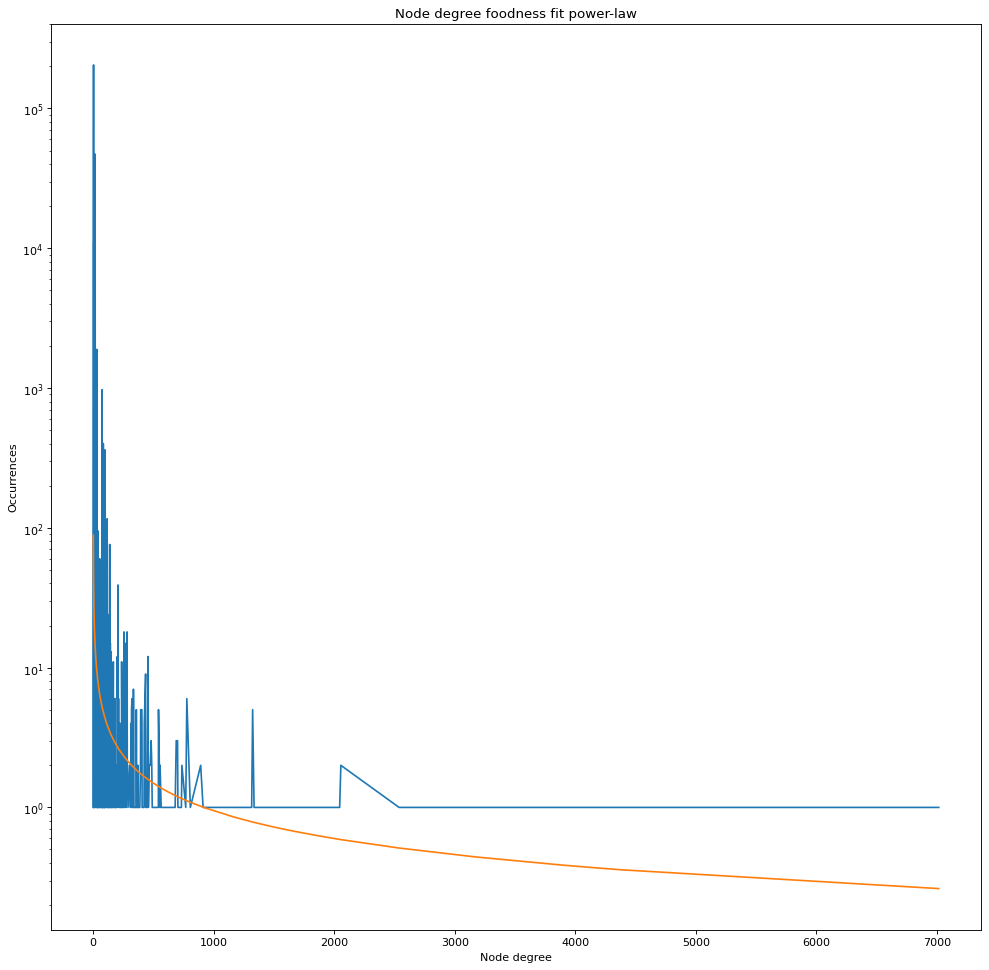

In [123]:
## Goodness fit to power law distribution
def powlaw(x, a, b) :
    return a * np.power(x, b)
def linlaw(x, a, b) :
    return a + x * b

def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale"""
    # Weights according to a log scale
    # Apply fscalex
    xdata_log = np.log10(xdata)
    # Apply fscaley
    ydata_log = np.log10(ydata)
    # Fit linear
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    #print(popt_log, pcov_log)
    # Apply fscaley^-1 to fitted data
    ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return (popt_log, pcov_log, ydatafit_log)

histogram_degrees = list(dict(G.degree()).values())
diccionario = dict(Counter(histogram_degrees))
xs = []
ys = []
for i,k in diccionario.items():
    xs.append(i)
    ys.append(k)

Z = [ys for _,x in sorted(zip(xs,ys))]
xs = sorted(xs)
popt_log, pcov_log, ydatafit_log= curve_fit_log(xs,ys)

plt.figure(figsize=(15, 15), dpi=80)
plt.plot(xs, ys)
plt.title('Node degree foodness fit power-law')
plt.xlabel('Node degree')
plt.ylabel('Occurrences')
plt.yscale('log')
plt.plot(xs, ydatafit_log)

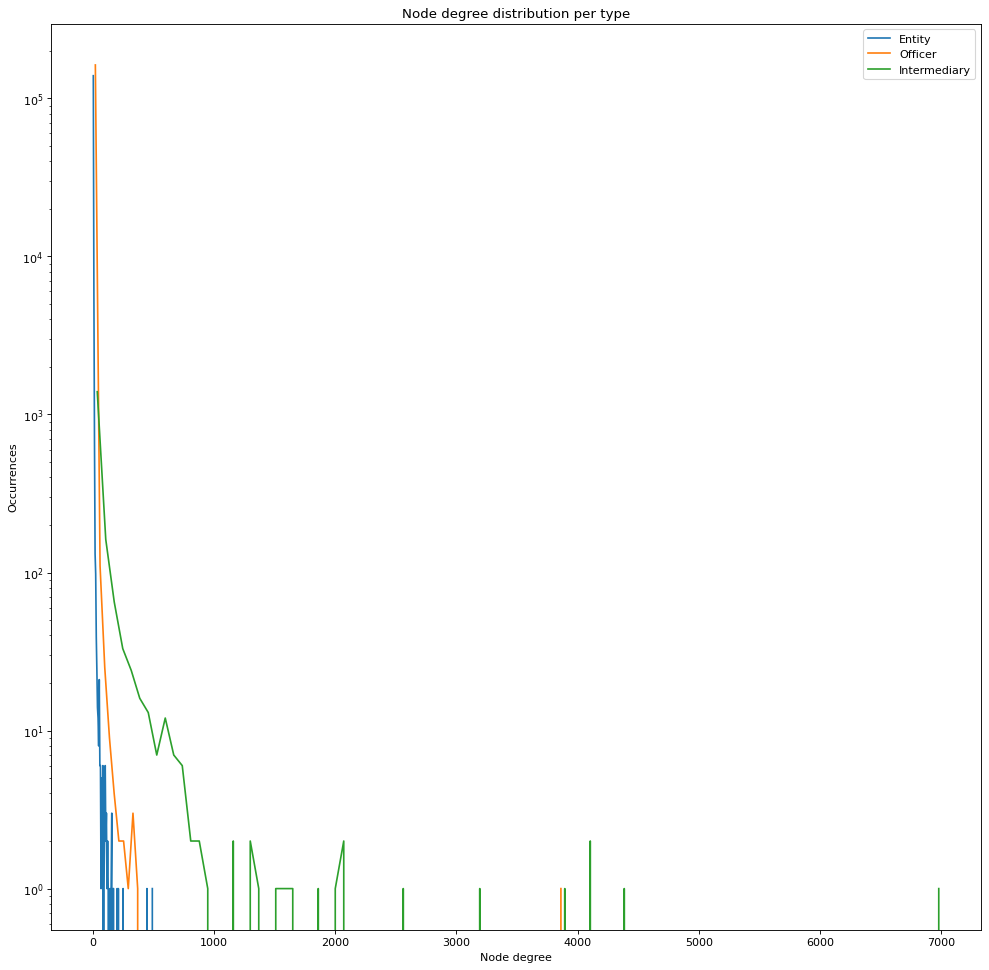

In [124]:
## Node degree per type
histogram_degrees_entity = list(dict(G.degree(labels['Entity'])).values())
histogram_degrees_officer = list(dict(G.degree(labels['Officer'])).values())
histogram_degrees_intermediaries = list(dict(G.degree(labels['Intermediary'])).values())

plt.figure(figsize=(15, 15), dpi=80)
y,binEdges=np.histogram(histogram_degrees_entity,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Entity")

y,binEdges=np.histogram(histogram_degrees_officer,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Officer")

y,binEdges=np.histogram(histogram_degrees_intermediaries,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Intermediary")

plt.title('Node degree distribution per type')
plt.xlabel('Node degree')
plt.ylabel('Occurrences')
plt.yscale('log')
plt.legend()
p.show()

In [125]:
## Node associativity compute

scatter_associativity = []
scatter_associativity_entity = []
scatter_associativity_officer = []
scatter_associativity_intermediary = []
scatter_associativity_mean = []
scatter_associativity_entity_mean = []
scatter_associativity_officer_mean = []
scatter_associativity_intermediary_mean = []
for node_id,metadata in G.nodes(data=True):
    node_degree = G.degree(node_id)
    degree_mean = 0
    number_of_neighbors = len(list(G.neighbors(node_id)))
    for node_neighbor in G.neighbors(node_id):
        neighbor_degree = G.degree(node_neighbor)
        degree_mean = neighbor_degree + degree_mean
        scatter_associativity.append(list([node_degree, neighbor_degree]))
        if G.nodes[node_id]['kind'] == 'Entity':
            scatter_associativity_entity.append(list([node_degree, neighbor_degree]))
        elif G.nodes[node_id]['kind'] == 'Officer':
            scatter_associativity_officer.append(list([node_degree, neighbor_degree]))
        else:
            scatter_associativity_intermediary.append(list([node_degree, neighbor_degree]))
    scatter_associativity_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
    if G.nodes[node_id]['kind'] == 'Entity':
        scatter_associativity_entity_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
    elif G.nodes[node_id]['kind'] == 'Officer':
        scatter_associativity_officer_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
    else:
        scatter_associativity_intermediary_mean.append(list([node_degree, degree_mean/number_of_neighbors]))

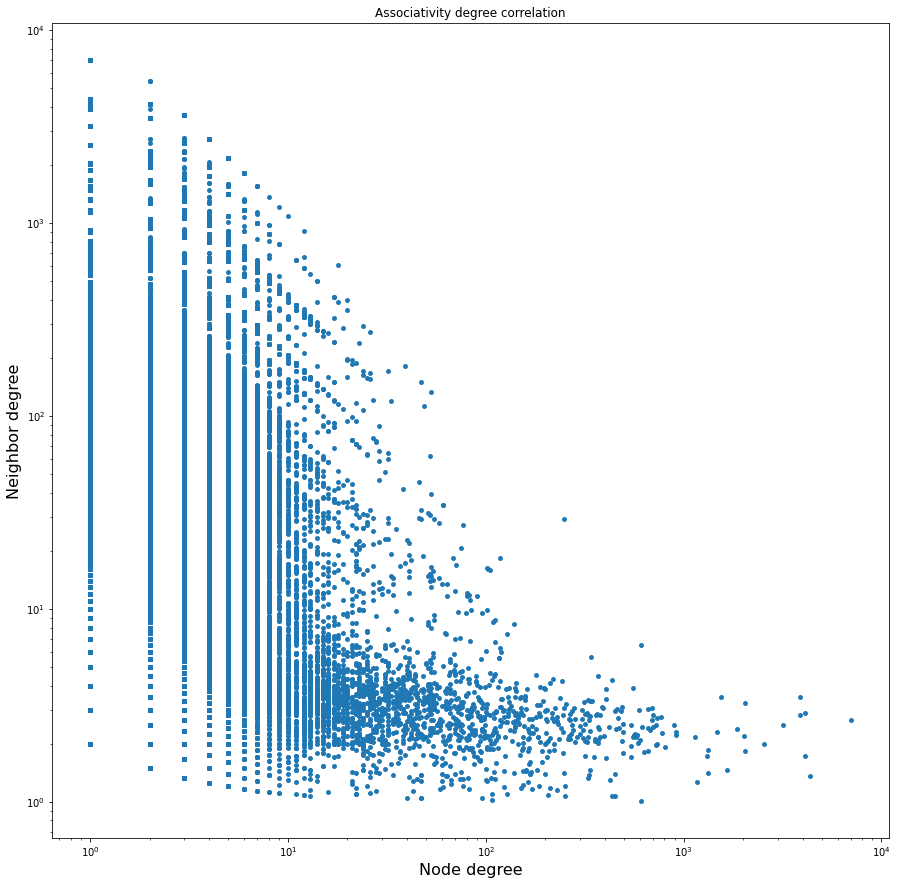

In [126]:
## Node associativity plot
fig, axs = plt.subplots(1,1,figsize=(15,15))
x,y = (np.array(scatter_associativity_mean)).T
plt.scatter(x,y,s=15)
plt.title('Associativity degree correlation')
plt.xlabel('Node degree', fontsize=16)
plt.ylabel('Neighbor degree', fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.show()

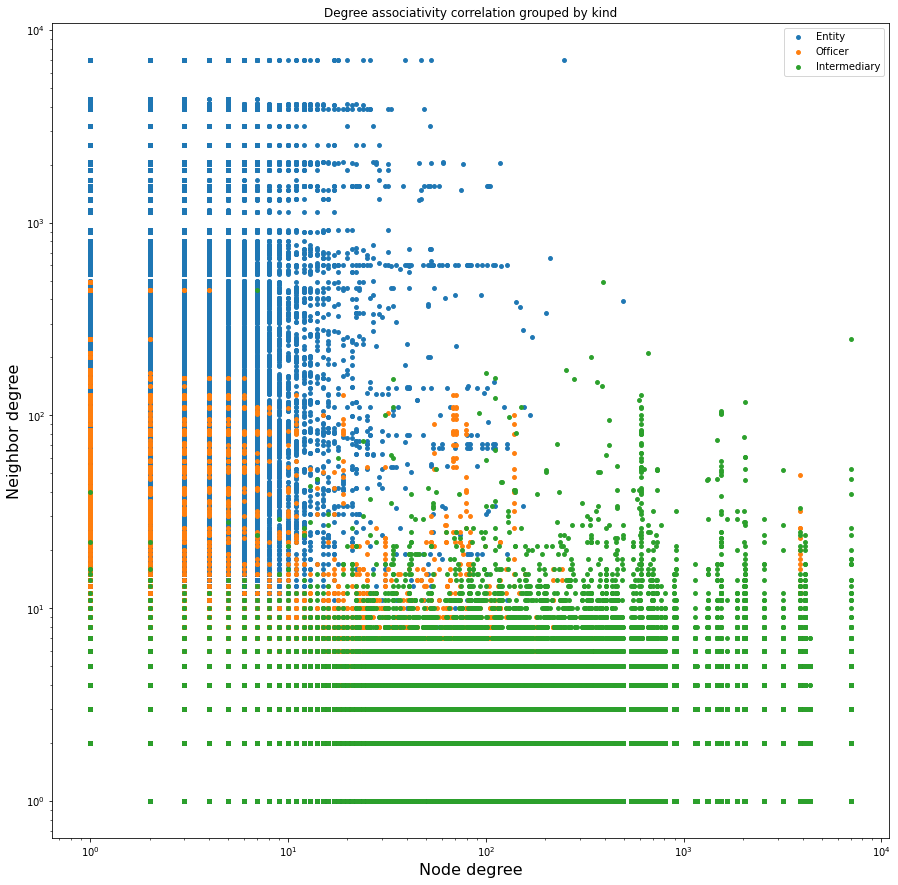

In [127]:
## Node associativity per node kind
x_entity,y_entity = (np.array(scatter_associativity_entity)).T
x_officer,y_officer = (np.array(scatter_associativity_officer)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_entity,y_entity,s=15,label="Entity")
plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Node degree', fontsize=16)
plt.ylabel('Neighbor degree', fontsize=16)
plt.title('Degree associativity correlation grouped by kind')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

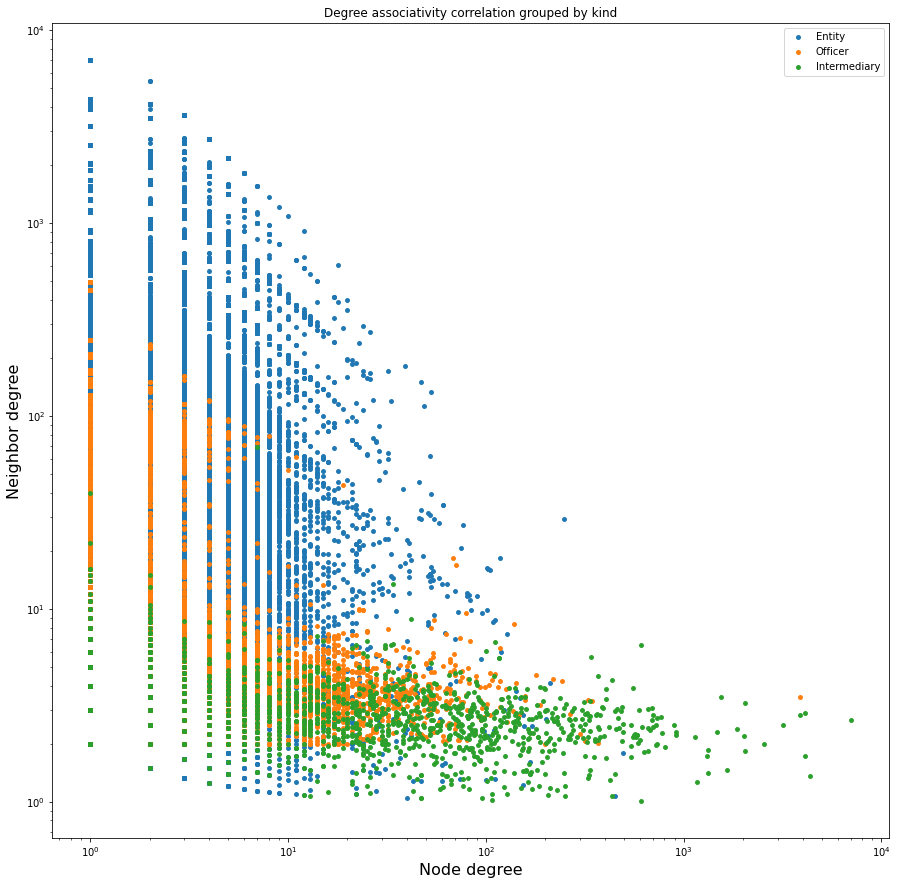

In [128]:
## Node associativity per node kind (neighbor mean)
x_entity,y_entity = (np.array(scatter_associativity_entity_mean)).T
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_entity,y_entity,s=15,label="Entity")
plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Node degree', fontsize=16)
plt.ylabel('Neighbor degree', fontsize=16)
plt.title('Degree associativity correlation grouped by kind')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [129]:
## Distribution of each kind of officer edges
shareholder = 0
beneficiary = 0
director    = 0
officer     = 0
for data in G.edges(labels['Officer'],data=True):
    if data[2]['type'] == 'SHAREHOLDER_OF':
        shareholder = shareholder +1
    elif data[2]['type'] == 'BENEFICIARY_OF':
        beneficiary = beneficiary +1
    elif data[2]['type'] == 'OFFICER_OF':
        officer = officer +1
    else:
        director = director +1

In [130]:
total_edges = sum(list(dict(G.degree(labels['Officer'])).values()))
print("Number of relationshipts known as 'shareholder_of': " , shareholder/total_edges*100)
print("Number of relationshipts known as 'beneficiary_of': " , beneficiary/total_edges*100)
print("Number of relationshipts known as 'director_of': " , director/total_edges*100)
print("Number of relationshipts known as 'officer_of': " , officer/total_edges*100)

Number of relationshipts known as 'shareholder_of':  94.79050501832086
Number of relationshipts known as 'beneficiary_of':  5.148113092616368
Number of relationshipts known as 'director_of':  0.011245536927531885
Number of relationshipts known as 'officer_of':  0.05013635213524632


In [179]:
print(nx.is_connected(G))
total_graph = G.number_of_nodes()
scatter = []

True


In [180]:
## Percolation first iteration
max_degree_id = max(dict(G.degree(labels['Intermediary'])), key=dict(G.degree(labels['Intermediary'])).get)
Percolation_graph = G.copy()
Percolation_graph.remove_node(max_degree_id)

print(nx.is_connected(Percolation_graph))

False


In [181]:
print("Number of nodes: ", Percolation_graph.number_of_nodes())
print("Number of edges: ", Percolation_graph.number_of_edges())

Number of nodes:  310673
Number of edges:  352407


In [182]:
Gcc = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
Gcc = Percolation_graph.subgraph(Gcc[0])
print('The total number of components is: ',len(Gcc))
print('Proportion' + str(len(Gcc)/total_graph))
scatter.append([1,len(Gcc)/total_graph])

The total number of components is:  299011
Proportion0.9624590406664221


In [183]:
## Percolation second iteration
max_degree_id = max(dict(Gcc.degree(labels['Intermediary'])), key=dict(Gcc.degree(labels['Intermediary'])).get)
Percolation_graph = Gcc.copy()
Percolation_graph.remove_node(max_degree_id)
Gcc = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
Gcc = Percolation_graph.subgraph(Gcc[0])
print('The total number of components is: ',len(Gcc))
print('Proportion' + str(len(Gcc)/total_graph))
scatter.append([1,len(Gcc)/total_graph])

The total number of components is:  295504
Proportion0.9511706805204169


In [227]:
## Percolation for GCC
total_graph = G.number_of_nodes()
scatter = [[0,1]]
current_length = total_graph
Percolation_graph = G.copy()
i=1
while current_length/total_graph > 0.22:
    max_degree_id = max(dict(Percolation_graph.degree(labels['Intermediary'])), key=dict(Percolation_graph.degree(labels['Intermediary'])).get)
    Percolation_graph.remove_node(max_degree_id)
    Gcc = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
    Gcc = Percolation_graph.subgraph(Gcc[0])
    current_length = len(Gcc)
    print('The total number of components is: ',current_length)
    print('Proportion',current_length/total_graph)
    Percolation_graph = Gcc.copy()
    scatter.append([i,current_length/total_graph])
    i=i+1

The total number of components is:  299011
Proportion 0.9624590406664221
The total number of components is:  295504
Proportion 0.9511706805204169
The total number of components is:  288021
Proportion 0.927084339210877
The total number of components is:  276893
Proportion 0.8912654422320503
The total number of components is:  268332
Proportion 0.8637092257478901
The total number of components is:  266107
Proportion 0.8565473776370086
The total number of components is:  261687
Proportion 0.8423202456594372
The total number of components is:  255493
Proportion 0.822382948041999
The total number of components is:  251787
Proportion 0.8104540450761892
The total number of components is:  247897
Proportion 0.7979328814126705
The total number of components is:  243682
Proportion 0.7843656051037422
The total number of components is:  241258
Proportion 0.776563214173056
The total number of components is:  237844
Proportion 0.765574203184045
The total number of components is:  235071
Proportion 0

The total number of components is:  145198
Proportion 0.4673645042713584
The total number of components is:  144521
Proportion 0.4651853711607666
The total number of components is:  143849
Proportion 0.4630223320908734
The total number of components is:  143513
Proportion 0.4619408125559268
The total number of components is:  143111
Proportion 0.4606468516837585
The total number of components is:  142625
Proportion 0.4590825109278536
The total number of components is:  141615
Proportion 0.4558315147067344
The total number of components is:  141349
Proportion 0.45497531174156836
The total number of components is:  141046
Proportion 0.45400001287523256
The total number of components is:  140698
Proportion 0.4528798676426093
The total number of components is:  140395
Proportion 0.4519045687762735
The total number of components is:  139712
Proportion 0.44970612281684336
The total number of components is:  139400
Proportion 0.4487018546772501
The total number of components is:  138854
Propo

The total number of components is:  107900
Proportion 0.3473093982760064
The total number of components is:  107527
Proportion 0.34610878283989005
The total number of components is:  107255
Proportion 0.34523326702588564
The total number of components is:  107092
Proportion 0.34470860129911096
The total number of components is:  107049
Proportion 0.3445701925491029
The total number of components is:  106825
Proportion 0.3438491795258052
The total number of components is:  106737
Proportion 0.34356592440950967
The total number of components is:  106346
Proportion 0.3423073704268783
The total number of components is:  105816
Proportion 0.34060140211282564
The total number of components is:  105617
Proportion 0.339960859293021
The total number of components is:  105348
Proportion 0.3390949999034358
The total number of components is:  105185
Proportion 0.33857033417666105
The total number of components is:  104936
Proportion 0.3377688509498703
The total number of components is:  104764
Pro

The total number of components is:  85715
Proportion 0.27590013969627325
The total number of components is:  85520
Proportion 0.27527247210902744
The total number of components is:  85431
Proportion 0.2749859981845922
The total number of components is:  85087
Proportion 0.27387872818452785
The total number of components is:  84821
Proportion 0.27302252521936177
The total number of components is:  84648
Proportion 0.2724656714111899
The total number of components is:  84559
Proportion 0.2721791974867546
The total number of components is:  84395
Proportion 0.2716513129518402
The total number of components is:  84226
Proportion 0.2711073343762272
The total number of components is:  83998
Proportion 0.27037344612037056
The total number of components is:  83893
Proportion 0.2700354712656997
The total number of components is:  83100
Proportion 0.2674829564109002
The total number of components is:  82978
Proportion 0.26709026181785406
The total number of components is:  82922
Proportion 0.266

The total number of components is:  72342
Proportion 0.23285501844377063
The total number of components is:  72232
Proportion 0.23250094954840123
The total number of components is:  72146
Proportion 0.23222413204838513
The total number of components is:  72100
Proportion 0.2320760668739579
The total number of components is:  72083
Proportion 0.23202134713558265
The total number of components is:  72006
Proportion 0.23177349890882404
The total number of components is:  71932
Proportion 0.23153530710648462
The total number of components is:  71787
Proportion 0.23106857992622493
The total number of components is:  71531
Proportion 0.23024456504245608
The total number of components is:  71491
Proportion 0.2301158127168672
The total number of components is:  71378
Proportion 0.2297520873970786
The total number of components is:  71269
Proportion 0.2294012373098489
The total number of components is:  71142
Proportion 0.22899244867610422
The total number of components is:  71134
Proportion 0.

In [229]:
scatter_sgcc = [[0,1]]
max_degree_id = max(dict(G.degree(labels['Intermediary'])), key=dict(G.degree(labels['Intermediary'])).get)
Percolation_graph = G.copy()
Percolation_graph.remove_node(max_degree_id)
Gcc = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
Percolation_graph = Percolation_graph.subgraph(Gcc[1])
current_length=len(Percolation_graph)
found = 0
for i in Percolation_graph:
    if Percolation_graph.nodes[i]['kind'] == 'Intermediary':
        found = 1
if found == 1:
    print('Follow')
else:
    print('Out')
for i in range(len(scatter)-1):
    scatter_sgcc.append([i,current_length/total_graph])

Out


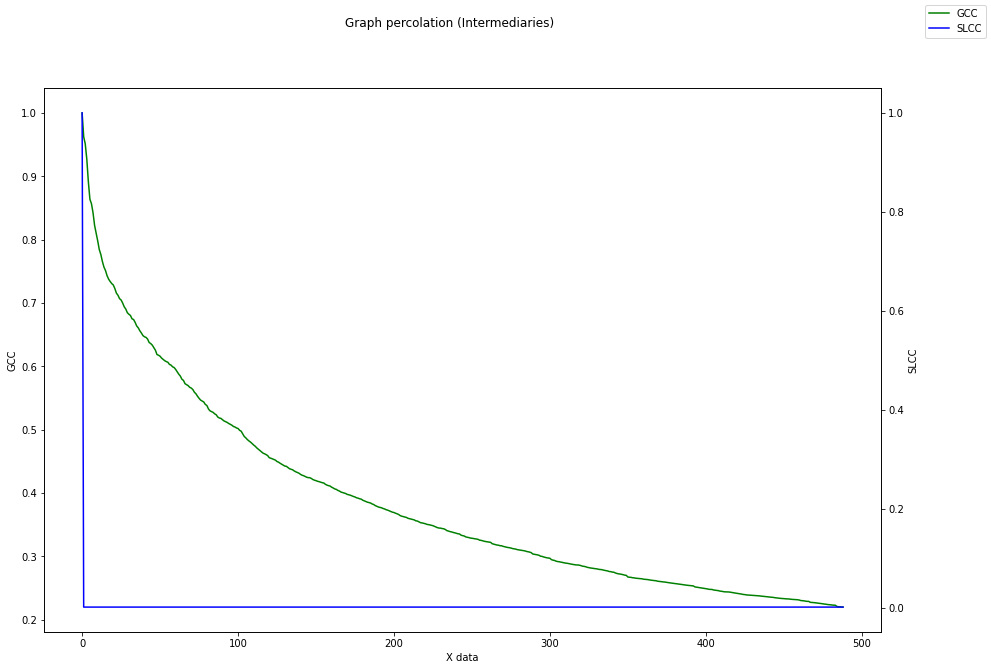

In [250]:
fig, ax1 = plt.subplots(figsize=(15,10))
fig.suptitle('Graph percolation (Intermediaries)')
x_val_gcc = [x[0] for x in scatter]
y_val_gcc = [x[1] for x in scatter]
x_val_sgcc = [x[0] for x in scatter_sgcc]
y_val_sgcc = [x[1] for x in scatter_sgcc]

ax2 = ax1.twinx()
ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")

ax1.set_xlabel('X data')
ax1.set_ylabel('GCC')
ax2.set_ylabel('SLCC')
fig.legend()
plt.show()

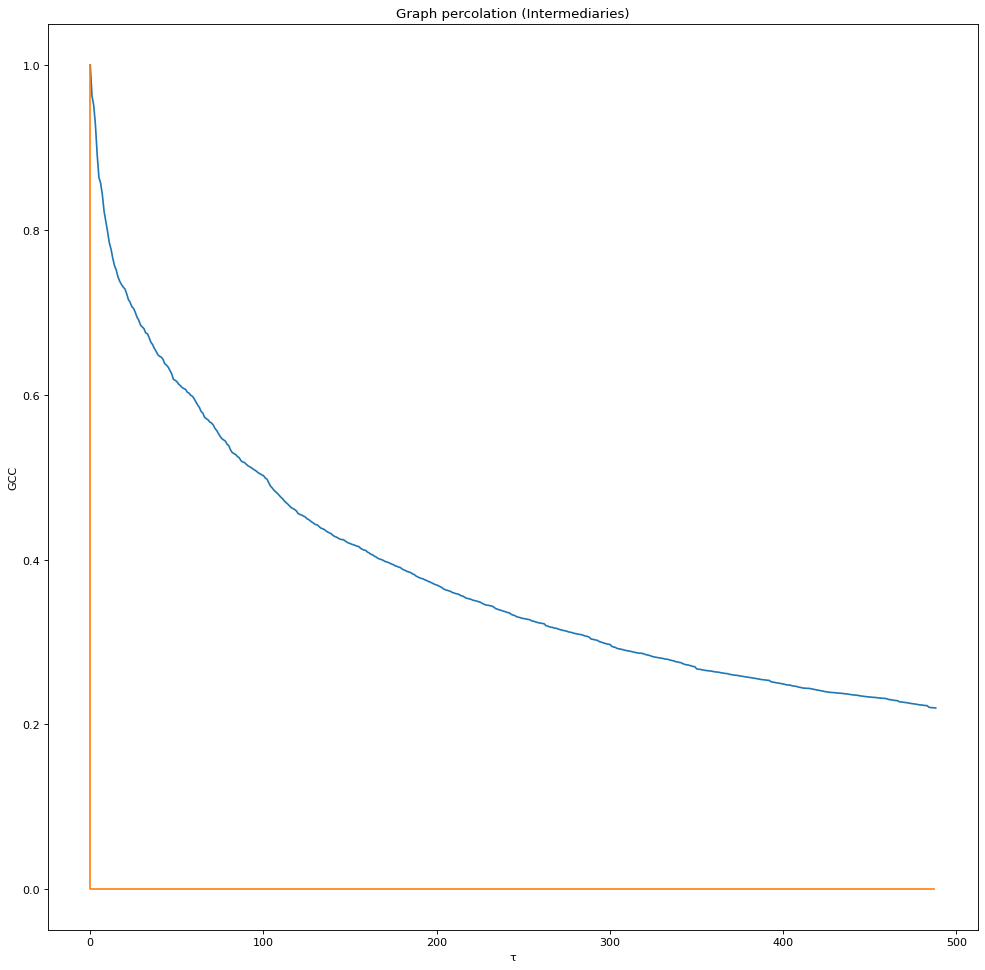

In [246]:
# Percolation plot
plt.figure(figsize=(15, 15), dpi=80)
x_val_gcc = [x[0] for x in scatter]
y_val_gcc = [x[1] for x in scatter]
x_val_sgcc = [x[0] for x in scatter_sgcc]
y_val_sgcc = [x[1] for x in scatter_sgcc]
plt.title('Graph percolation (Intermediaries)')
plt.xlabel('τ')
plt.ylabel('GCC')
plt.plot(x_val_gcc,y_val_gcc)
plt.plot(x_val_sgcc,y_val_sgcc)
plt.show()

In [151]:
S = [Percolation_graph_2.subgraph(c).copy() for c in nx.connected_components(Percolation_graph_2)]

In [152]:
print('The total number of components is: ',len(S))

The total number of components is:  7793


In [153]:
# Component size
nodes_per_component = []
for subgraph in S:
    nodes_per_component.append(subgraph.number_of_nodes())

In [154]:
nodes_per_component

[295504,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 5,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 64,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 9,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1

In [36]:
A = nx.adjacency_matrix(G)

In [37]:
def get_stats(stats):
    array = list(stats.values())
    response = {
        "min": min(array),
        "max": max(array),
        "mean": np.mean(array),
        "std": np.std(array)
    }
    return response

In [38]:
## Degree centrality
stats_degree_centrality = get_stats(nx.degree_centrality(G))
print(stats_degree_centrality)

{'min': 3.218818500481213e-06, 'max': 0.02258323059937619, 'mean': 7.447790300433631e-06, 'std': 8.430010369957995e-05}


In [39]:
## Information centrality
stats_information_centrality = get_stats(nx.information_centrality(G))
print(stats_information_centrality)

KeyboardInterrupt: 

In [ ]:
## Closeness centrality
stats_closeness_centrality = get_stats(nx.closeness_centrality(G))
print(stats_closeness_centrality)

In [ ]:
## Betwenness centrality
stats_betweenness_centrality = get_stats(nx.betweenness_centrality(G, k=100))
print(stats_betweenness_centrality)

In [ ]:
stats_current_flow_closeness_centrality = get_stats(nx.current_flow_closeness_centrality(G))